# LSTM Stress Level Predictor
## Step-by-Step Verification and Training Workflow

This notebook trains an LSTM model to predict stress levels using 60-minute sliding windows of health, weather, and network data.

---
## CELL 1: SETUP & DATA VERIFICATION

In [1]:
# Import required libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Load the .npy files
print("\nLoading data...")
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Print shapes
print("\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  y_train: {y_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

# Assert check for NaNs
assert not np.isnan(X_train).any(), "ERROR: X_train contains NaN values!"
assert not np.isnan(y_train).any(), "ERROR: y_train contains NaN values!"
assert not np.isnan(X_test).any(), "ERROR: X_test contains NaN values!"
assert not np.isnan(y_test).any(), "ERROR: y_test contains NaN values!"

# Verify shapes are correct
assert X_train.shape[1] == 60, "ERROR: X_train should have 60 time steps!"
assert X_test.shape[1] == 60, "ERROR: X_test should have 60 time steps!"
assert X_train.shape[2] == X_test.shape[2], "ERROR: Feature count mismatch!"

print("\n✓ Data Loaded Successfully")
print(f"\nInput shape for LSTM: (batch_size, {X_train.shape[1]}, {X_train.shape[2]})")

TensorFlow version: 2.19.0
Keras version: 3.9.2

Loading data...

Data shapes:
  X_train: (32728, 60, 23)
  y_train: (32728,)
  X_test: (8183, 60, 23)
  y_test: (8183,)

✓ Data Loaded Successfully

Input shape for LSTM: (batch_size, 60, 23)


---
## CELL 2: MODEL ARCHITECTURE BUILDER

In [2]:
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model for stress level prediction.
    
    Architecture:
    - LSTM(64) with return_sequences=True
    - Dropout(0.2)
    - LSTM(32) with return_sequences=False
    - Dense(16, relu)
    - Dense(1, linear) - output layer
    
    Parameters:
    - input_shape: tuple (time_steps, features)
    
    Returns:
    - Compiled Keras model
    """
    model = Sequential([
        # First LSTM layer - returns sequences for the next LSTM layer
        LSTM(64, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        
        # Dropout to prevent overfitting
        Dropout(0.2, name='dropout_1'),
        
        # Second LSTM layer - returns only the last output
        LSTM(32, return_sequences=False, name='lstm_2'),
        
        # Dense hidden layer
        Dense(16, activation='relu', name='dense_1'),
        
        # Output layer - single value (stress level)
        Dense(1, activation='linear', name='output')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']  # Mean Absolute Error for monitoring
    )
    
    return model

# Display the function
print("✓ Model builder function defined")
print("\nFunction signature: build_lstm_model(input_shape)")
print("Returns: Compiled LSTM model")

✓ Model builder function defined

Function signature: build_lstm_model(input_shape)
Returns: Compiled LSTM model


---
## CELL 3: SANITY CHECK (PREDICTION)

In [3]:
# Build a fresh model instance
print("Building model for sanity check...")
input_shape = (X_train.shape[1], X_train.shape[2])  # (60, 23)
model = build_lstm_model(input_shape)

# Display model summary
print("\nModel Architecture:")
model.summary()

# Select a single sample from X_train
sample = X_train[0:1]  # Shape: (1, 60, 23)
print(f"\nSample shape: {sample.shape}")

# Run prediction
print("\nRunning prediction on sample...")
prediction = model.predict(sample, verbose=0)

print(f"\n✓ Prediction successful!")
print(f"Predicted stress level (normalized): {prediction[0][0]:.4f}")
print(f"Actual stress level (normalized): {y_train[0]:.4f}")
print(f"\nNote: Model has random weights - prediction is meaningless at this stage.")
print("Purpose: Verify model accepts input shape without errors.")

Building model for sanity check...

Model Architecture:


c:\Users\shaba\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,489 (138.63 KB)

 Trainable params: 35,489 (138.63 KB)

 Non-trainable params: 0 (0.00 B)


Sample shape: (1, 60, 23)

Running prediction on sample...

✓ Prediction successful!
Predicted stress level (normalized): -0.2978
Actual stress level (normalized): -0.3264

Note: Model has random weights - prediction is meaningless at this stage.
Purpose: Verify model accepts input shape without errors.


---
## CELL 4: STABILITY TEST (SHORT TRAINING)

In [4]:
# Re-build a fresh model to reset weights
print("Building fresh model for stability test...")
model = build_lstm_model(input_shape)

# Run short training (3 epochs)
print("\nRunning stability test: 3 epochs with batch_size=32")
print("Purpose: Check if loss decreases and ensure no NaN loss occurs\n")

history = model.fit(
    X_train, y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=1
)

# Check for NaN loss
final_loss = history.history['loss'][-1]
assert not np.isnan(final_loss), "ERROR: Loss became NaN during training!"

print("\n✓ Stability test passed!")
print(f"Initial loss: {history.history['loss'][0]:.4f}")
print(f"Final loss: {history.history['loss'][-1]:.4f}")

if history.history['loss'][-1] < history.history['loss'][0]:
    print("✓ Loss is decreasing - model is learning!")
else:
    print("⚠ Warning: Loss did not decrease in 3 epochs (may need more time)")

Building fresh model for stability test...

Running stability test: 3 epochs with batch_size=32
Purpose: Check if loss decreases and ensure no NaN loss occurs

Epoch 1/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - loss: 0.2985 - mae: 0.4049 - val_loss: 0.1507 - val_mae: 0.2862
Epoch 2/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.1361 - mae: 0.2707 - val_loss: 0.1323 - val_mae: 0.2650
Epoch 3/3
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 0.1228 - mae: 0.2542 - val_loss: 0.1343 - val_mae: 0.2661

✓ Stability test passed!
Initial loss: 0.2039
Final loss: 0.1246
✓ Loss is decreasing - model is learning!


---
## CELL 5: FULL TRAINING & VISUALIZATION

Building final model for full training...

Starting full training: 50 epochs with early stopping

Epoch 1/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.2733 - mae: 0.3817 - val_loss: 0.1541 - val_mae: 0.2855
Epoch 2/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.1339 - mae: 0.2671 - val_loss: 0.1353 - val_mae: 0.2648
Epoch 3/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.1243 - mae: 0.2531 - val_loss: 0.1364 - val_mae: 0.2650
Epoch 4/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.1205 - mae: 0.2494 - val_loss: 0.1366 - val_mae: 0.2690
Epoch 5/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - loss: 0.1206 - mae: 0.2494 - val_loss: 0.1346 - val_mae: 0.2599
Epoch 6/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.1175 - mae: 0.2454 - val_loss: 0.1336 - val_mae: 0.2592
Epoch 7/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - loss: 0.1154 - mae: 0.2420 - val_loss: 0.1330 - val_mae: 0.2604
Epoch 8/50
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 27s 26

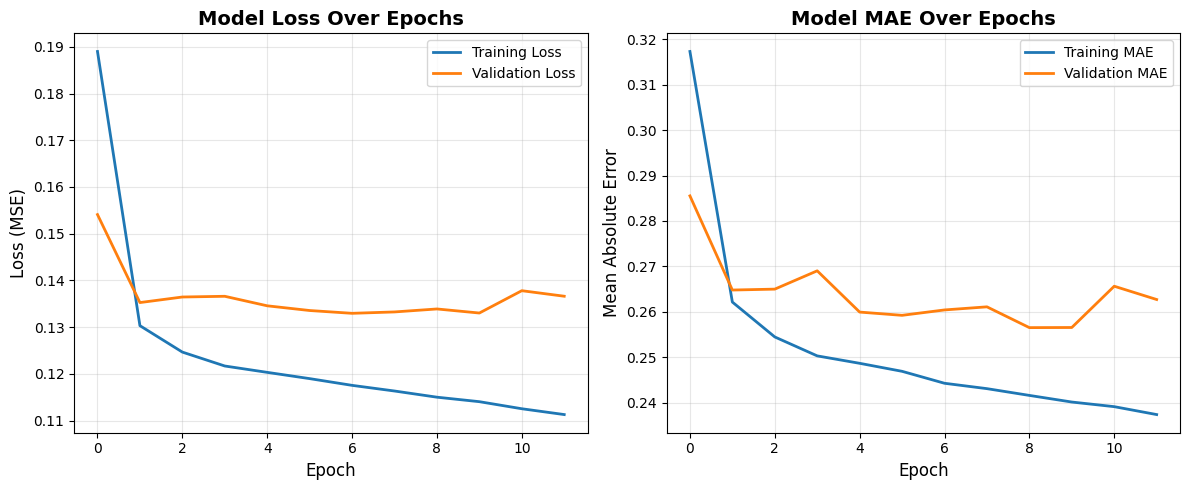


Saving model to: stress_predictor_model.keras
✓ Model saved successfully!

FINAL RESULTS

Training Set:
  Loss (MSE): 0.1108
  MAE: 0.2359

Test Set:
  Loss (MSE): 0.1330
  MAE: 0.2604

Total epochs trained: 12
Best validation loss: 0.1330

✓ All tasks completed successfully!


In [5]:
# Re-build a fresh model one last time
print("Building final model for full training...\n")
model = build_lstm_model(input_shape)

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Run full training
print("Starting full training: 50 epochs with early stopping\n")
print("="*80)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),  # Use test set for validation
    callbacks=[early_stopping],
    verbose=1
)

print("\n" + "="*80)
print("✓ Training complete!\n")

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Absolute Error', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the final model
model_path = 'stress_predictor_model.keras'
print(f"\nSaving model to: {model_path}")
model.save(model_path)
print("✓ Model saved successfully!")

# Final evaluation
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)

train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTraining Set:")
print(f"  Loss (MSE): {train_loss:.4f}")
print(f"  MAE: {train_mae:.4f}")

print(f"\nTest Set:")
print(f"  Loss (MSE): {test_loss:.4f}")
print(f"  MAE: {test_mae:.4f}")

print(f"\nTotal epochs trained: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")

print("\n" + "="*80)
print("✓ All tasks completed successfully!")
print("="*80)

In [16]:
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

# 1. Load the Model and the Scaler
model = load_model('stress_predictor_model.keras')
scaler = joblib.load('health_net_features_2_scalar.pkl')

print("Model and Scaler loaded successfully.")

# 2. Grab a random sample from X_test to test the model
# Let's pick sample #10
sample_idx = 56
input_sequence = X_test[sample_idx].reshape(1, 60, X_test.shape[2]) # Reshape to (1, 60, features)
actual_scaled_value = y_test[sample_idx]

# 3. Make a Prediction (This comes out as a Scaled Number, e.g., 0.5)
predicted_scaled_value = model.predict(input_sequence)[0][0]

print(f"\n--- Raw Model Output (Z-Scores) ---")
print(f"Predicted: {predicted_scaled_value:.4f}")
print(f"Actual:    {actual_scaled_value:.4f}")

# 4. The Magic Trick: Inverse Transform to get REAL Stress Levels
# We need to create a dummy array to satisfy the scaler's shape requirement
# The scaler expects [features], so we create a row of zeros and put our target in the 'stress_level' spot

# We need to find which index corresponds to 'stress_level'
# (Assuming you know the column order from your dataframe)
# For this example, let's assume 'stress_level' was the 2nd column (index 1) in your feature list.
# You might need to adjust 'target_col_index' based on your specific feature list order.
target_col_index = 1 

def inverse_transform_target(scaled_val, scaler, target_idx):
    dummy = np.zeros((1, scaler.n_features_in_))
    dummy[0, target_idx] = scaled_val
    unscaled = scaler.inverse_transform(dummy)[0, target_idx]
    return unscaled

real_prediction = inverse_transform_target(predicted_scaled_value, scaler, target_col_index)
real_actual = inverse_transform_target(actual_scaled_value, scaler, target_col_index)

print(f"\n--- REAL WORLD VALUES (0-100) ---")
print(f"Model Predicts Stress Level: {real_prediction:.1f}")
print(f"Actual Garmin Stress Level:  {real_actual:.1f}")
print(f"Error: {abs(real_prediction - real_actual):.1f} points")

Model and Scaler loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step

--- Raw Model Output (Z-Scores) ---
Predicted: -0.4597
Actual:    -0.1998

--- REAL WORLD VALUES (0-100) ---
Model Predicts Stress Level: 26.8
Actual Garmin Stress Level:  33.0
Error: 6.2 points


Generating predictions for the entire test set...
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

FINAL MODEL RESULTS (0-100 Scale)
Average Error (MAE):      +/- 6.17 points
Root Mean Sq Error (RMSE):    8.65 points


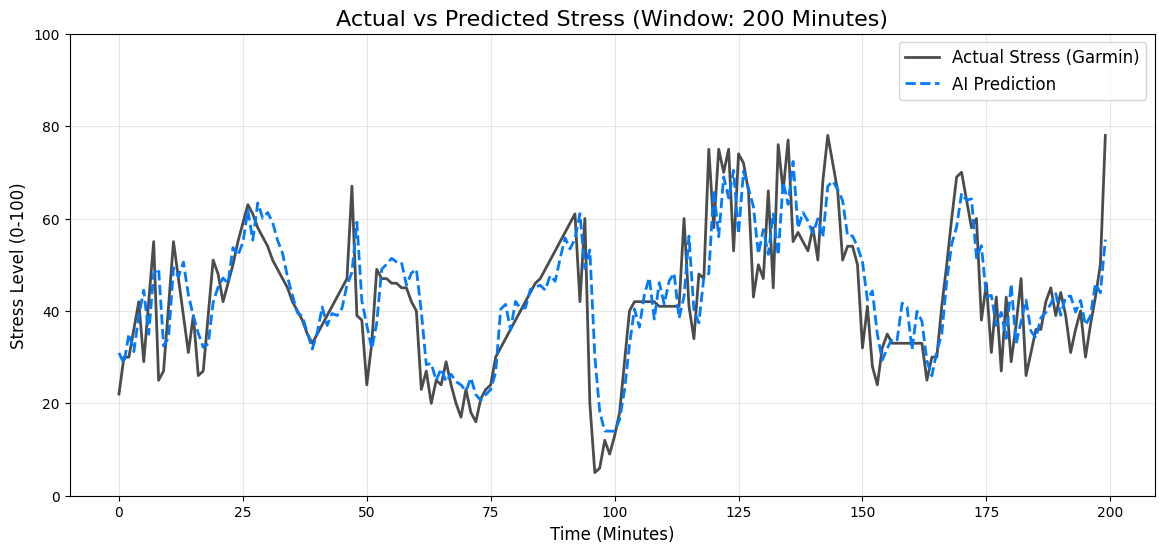

In [17]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Load everything (if not already loaded)
model = load_model('stress_predictor_model.keras')
scaler = joblib.load('health_net_features_2_scalar.pkl')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print("Generating predictions for the entire test set...")

# 2. Bulk Prediction (Super fast on GPU/CPU)
# predicted_scaled shape: (samples, 1)
predicted_scaled = model.predict(X_test)

# 3. Inverse Transform (Batch Method)
# We need to convert thousands of Z-scores back to Stress Levels at once.
# Since the scaler expects ALL features, we use a "Dummy Matrix" trick.

# Find column index for 'stress_level' (Adjust if your feature order is different!)
# Based on your previous CSV preview, stress_level was at index 1.
TARGET_COL_INDEX = 1 
num_features = scaler.n_features_in_

def batch_inverse_transform(scaled_target_array, scaler, target_index):
    # Create a dummy matrix filled with zeros
    dummy = np.zeros((len(scaled_target_array), scaler.n_features_in_))
    # Paste our predictions into the correct column
    dummy[:, target_index] = scaled_target_array.flatten()
    # Inverse transform the whole matrix
    unscaled_matrix = scaler.inverse_transform(dummy)
    # Extract just the target column
    return unscaled_matrix[:, target_index]

# Convert Predictions and Actuals
y_pred_real = batch_inverse_transform(predicted_scaled, scaler, TARGET_COL_INDEX)
y_test_real = batch_inverse_transform(y_test, scaler, TARGET_COL_INDEX)

# 4. Calculate "Real World" Accuracy
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print(f"\n========================================")
print(f"FINAL MODEL RESULTS (0-100 Scale)")
print(f"========================================")
print(f"Average Error (MAE):      +/- {mae:.2f} points")
print(f"Root Mean Sq Error (RMSE):    {rmse:.2f} points")
print(f"========================================")

# 5. Visualize a 200-Minute Window
# We plot a slice because plotting all 6000+ points looks messy
start_idx = 100
end_idx = 300  # View a 3-hour, 20-minute window

plt.figure(figsize=(14, 6))
plt.plot(y_test_real[start_idx:end_idx], label='Actual Stress (Garmin)', color='black', alpha=0.7, linewidth=2)
plt.plot(y_pred_real[start_idx:end_idx], label='AI Prediction', color='#007aff', linewidth=2, linestyle='--')

plt.title(f'Actual vs Predicted Stress (Window: {end_idx - start_idx} Minutes)', fontsize=16)
plt.ylabel('Stress Level (0-100)', fontsize=12)
plt.xlabel('Time (Minutes)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100) # Fix y-axis to stress range
plt.show()

Analyzing importance for 23 features...
Baseline MAE: 0.2604
Processed: heart_rate
Processed: stress_level
Processed: body_battery
Processed: sleep_duration_of_day
Processed: temperature_celsius
Processed: rain_mm
Processed: cloud_cover_percent
Processed: wind_speed_kmh
Processed: total_data_bytes
Processed: total_upload_bytes
Processed: total_download_bytes
Processed: phone_active
Processed: stress_rolling_mean_30
Processed: stress_volatility_30
Processed: battery_drain_rate_1hr
Processed: screen_streak_minutes
Processed: minute_sin
Processed: minute_cos
Processed: hour_sin
Processed: hour_cos
Processed: day_sin
Processed: day_cos
Processed: is_weekend


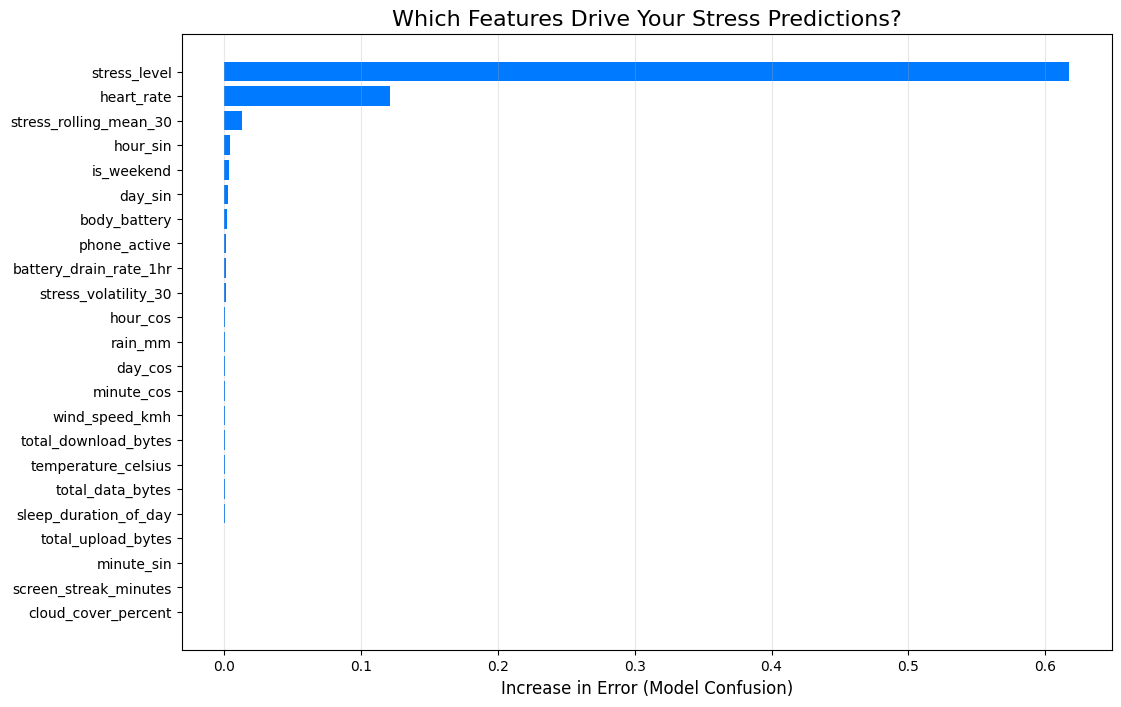

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error

# 1. Load Data and Model
model = load_model('stress_predictor_model.keras')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# 2. Get Feature Names (We need to load the CSV just to grab the names)
# Make sure to drop the same columns you dropped during training!
df_temp = pd.read_csv('health_net_features_2_normalize.csv')
features_df = df_temp.drop(columns=['datetime', 'date', 'time', 'hour', 'minute', 
                                    'day_of_week', 'day_numeric'])
feature_names = features_df.columns.tolist()

print(f"Analyzing importance for {len(feature_names)} features...")

# 3. Calculate Baseline Error
# We assume the model predicts Z-scores, so we measure error in Z-scores (it's faster)
baseline_pred = model.predict(X_test, verbose=0)
baseline_mae = mean_absolute_error(y_test, baseline_pred)
print(f"Baseline MAE: {baseline_mae:.4f}")

# 4. Loop through every feature to calculate "Drop in Accuracy"
importance_scores = []

for i, col_name in enumerate(feature_names):
    # a. Create a copy of the test set so we don't break the original
    X_test_shuffled = X_test.copy()
    
    # b. Shuffle the feature column (i) across all samples
    # We shuffle the 'samples' axis (axis 0), keeping time/feature structure intact
    # This breaks the link between "feature X" and the "target"
    np.random.shuffle(X_test_shuffled[:, :, i])
    
    # c. Predict with the broken feature
    shuffled_pred = model.predict(X_test_shuffled, verbose=0)
    shuffled_mae = mean_absolute_error(y_test, shuffled_pred)
    
    # d. Calculate Importance (How much worse did it get?)
    # Importance = New Error - Baseline Error
    importance = shuffled_mae - baseline_mae
    importance_scores.append(importance)
    print(f"Processed: {col_name}")

# 5. Visualize
plt.figure(figsize=(12, 8))
# Create a DataFrame for easy sorting
imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
imp_df = imp_df.sort_values(by='Importance', ascending=True)

plt.barh(imp_df['Feature'], imp_df['Importance'], color='#007aff')
plt.xlabel('Increase in Error (Model Confusion)', fontsize=12)
plt.title('Which Features Drive Your Stress Predictions?', fontsize=16)
plt.grid(True, alpha=0.3, axis='x')
plt.show()